## Experiments with visualizing point clouds in dune grass

The 2 m x 2 m snippets of point clouds were extracted with Cloud Compare, 
and saved with options of "comma separated" and "save colors as floating point".


In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# read the csv file into a numpy array. Dan Buscombe has a much faster way to do this in pysesa.
#dn = r"C:\\crs\\proj\\point_clouds\\cc\\"
dn = r"F:\\cc\\"
fn = r"p3.txt"
name = fn[0:-4]
print(name)
p = np.genfromtxt(dn+fn, delimiter=',')
print(np.shape(p))

p3
(11149, 9)


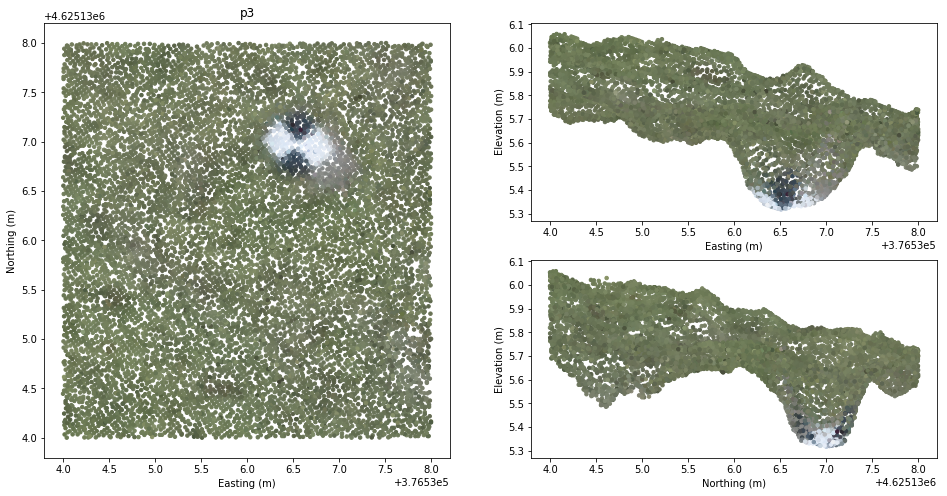

In [16]:
# plot points with original colors
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(p[:,0],p[:,1],s=12,c=p[:,3:6],edgecolor='face')
plt.title(name)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.subplot(2,2,2)
plt.scatter(p[:,0],p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.xlabel('Easting (m)')
plt.ylabel('Elevation (m)')
plt.subplot(2,2,4)
plt.scatter(p[:,1],p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.savefig(dn+name+".png",bbox_inches="tight")

In [17]:
# Mean of colors
np.mean(p[:,3:6],0)

array([ 0.42859521,  0.46650278,  0.35466996])

In [18]:
# covariance matrix
C = np.cov(p[:,3:6].T)
print("Covariance matrix:\n",C)
# eigenfunctions
eigval, eigvec = np.linalg.eig(C)
print("Eigenvalues:\n",eigval)
print("Eigenvectors:\n",eigvec)

Covariance matrix:
 [[ 0.00366967  0.0035662   0.00399541]
 [ 0.0035662   0.00360565  0.00388861]
 [ 0.00399541  0.00388861  0.00518857]]
Eigenvalues:
 [  1.18618440e-02   6.79860621e-05   5.34064041e-04]
Eigenvectors:
 [[-0.54700489 -0.73797135 -0.39520114]
 [-0.5382513   0.67161845 -0.50913082]
 [-0.64114833  0.06577952  0.76459262]]


In [19]:
# Normally, we would have to sort these, but in this case, the first eigenvalue is largest.
# Rotate the colors to the first eigenvector
W = eigvec[0,:]
t = W.T.dot(p[:,3:6].T)
print(np.shape(t))

(11149,)


In [20]:
# Fit line using all data
X = t.reshape(-1,1) # Don't understand why this is necessary
y = p[:,2]
print(np.shape(X))
print(np.shape(y))

(11149, 1)
(11149,)


In [21]:
# This is copied from the example in:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max(),.1)[:, None]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

Estimated coefficients (linear regression, RANSAC):
[ 0.34108976] [-0.18792031]


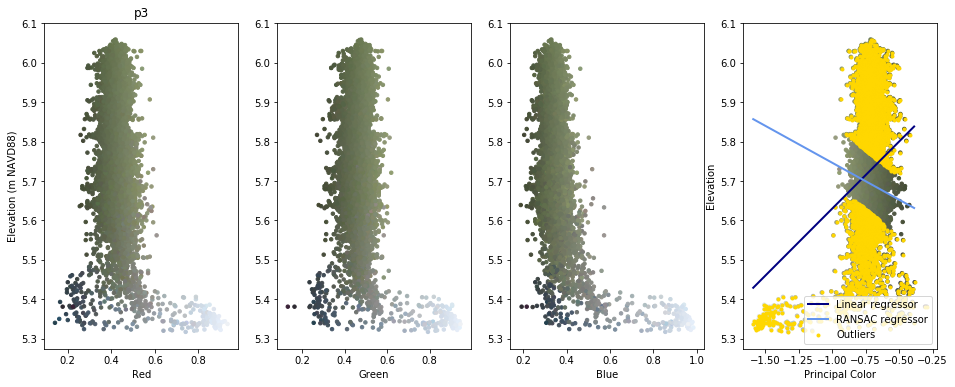

In [22]:
# plot color v. elevation, with original colors
plt.subplots(figsize=(16,6))
plt.subplot(1,4,1)
plt.scatter(p[:,3],p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.title(name)
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Red')
plt.subplot(1,4,2)
plt.scatter(p[:,4],p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.xlabel('Green')
plt.subplot(1,4,3)
plt.scatter(p[:,5],p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.xlabel('Blue')
# Plot first eigenvalue v. elevation w/ original colors
plt.subplot(1,4,4)
plt.scatter(t,p[:,2],s=12,c=p[:,3:6],edgecolor='face')
plt.xlabel('Principal Component')

#plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
#            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=2, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=2,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Principal Color")
plt.ylabel("Elevation")
plt.show()

plt.savefig(dn+name+"_elev.png",bbox_inches="tight")